In [2]:
import pandas as pd
import os 

# Set working directory and file paths
working_directory = os.getcwd()
test_measure_path = os.path.join(working_directory, 'test_measure.csv')
subject_info_path = os.path.join(working_directory, 'subject-info.csv')

# Load datasets
data = pd.read_csv(test_measure_path)
subject_info = pd.read_csv(subject_info_path)

# Drop rows with missing values in test_measure
cleaned_data = data.dropna()

# Find IDs of subjects with age > 18
adult_ids = subject_info[subject_info['Age'] > 18]['ID'].unique()

# Filter cleaned_data to include only rows with matching IDs
filtered_data = cleaned_data[cleaned_data['ID'].isin(adult_ids)]


# Optional: slice a range of rows if needed
start_index = 0
end_index = 20
subset_data = filtered_data.iloc[start_index:end_index]

# Display the result
print(f"\nFiltered data for IDs with age > 18 (rows {start_index} to {end_index}):\n", subset_data)

filtered_data.head()



Filtered data for IDs with age > 18 (rows 0 to 20):
     time  Speed     HR    VO2   VCO2  RR    VE ID_test  ID
0      0    5.0   63.0  478.0  360.0  27  13.3     2_1   2
1      2    5.0   75.0  401.0  295.0  23  10.3     2_1   2
2      4    5.0   82.0  449.0  319.0  29  12.2     2_1   2
3      7    5.0   87.0  461.0  340.0  28  12.8     2_1   2
4      9    5.0   92.0  574.0  417.0  28  14.6     2_1   2
5     11    5.0   94.0  624.0  458.0  26  15.7     2_1   2
6     14    5.0   95.0  619.0  451.0  26  15.4     2_1   2
7     16    5.0   96.0  681.0  493.0  26  16.4     2_1   2
8     17    5.0   97.0  776.0  572.0  26  18.5     2_1   2
9     19    5.0   97.0  774.0  576.0  27  19.0     2_1   2
10    21    5.0   98.0  738.0  554.0  27  18.5     2_1   2
11    24    5.0   98.0  746.0  569.0  26  18.8     2_1   2
12    27    5.0   99.0  715.0  542.0  27  18.0     2_1   2
13    29    5.0  100.0  746.0  570.0  27  18.9     2_1   2
14    31    5.0  101.0  657.0  501.0  26  16.7     2_1   2
15

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2


Age for ID = 2 is: 33.8


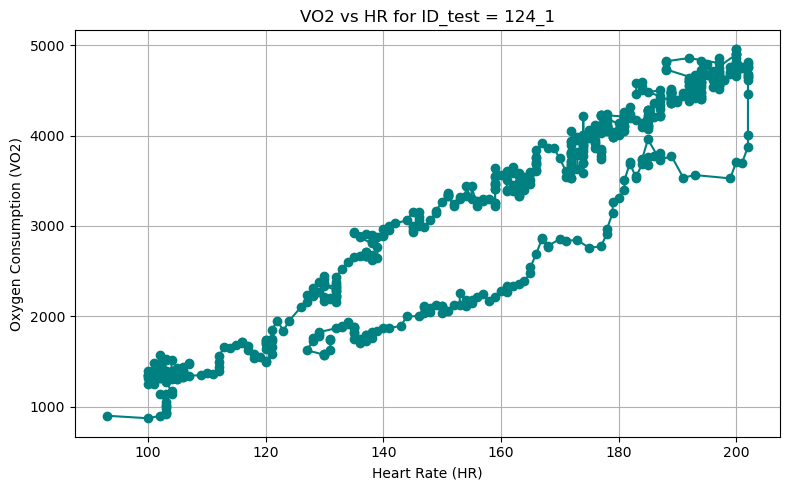

In [42]:
## SANITY CHECK

import pandas as pd
import os

# Set working directory and file path
working_directory = os.getcwd()
subject_info_path = os.path.join(working_directory, 'subject-info.csv')

# Load subject info data
subject_info = pd.read_csv(subject_info_path)

# Look for ID = 2
id_to_check = 2
age_row = subject_info[subject_info['ID'] == id_to_check]

# Print result
if not age_row.empty:
    age_value = age_row['Age'].values[0]
    print(f"Age for ID = {id_to_check} is: {age_value}")
else:
    print(f"No entry found for ID = {id_to_check}")
    
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set working directory and file path
working_directory = os.getcwd()
subject_measure_path = 'test_measure.csv'

# Load the dataset
data = pd.read_csv(subject_measure_path)

# Select specific ID_test
target_id_test = "124_1"
subset = data[data['ID_test'] == target_id_test]

# Check if relevant columns exist
if 'VO2' in subset.columns and 'HR' in subset.columns:
    # Plot VO2 vs HR
    plt.figure(figsize=(8, 5))
    plt.plot(subset['HR'], subset['VO2'], marker='o', color='teal')
    plt.title(f'VO2 vs HR for ID_test = {target_id_test}')
    plt.xlabel('Heart Rate (HR)')
    plt.ylabel('Oxygen Consumption (VO2)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("VO2 or HR column not found in the dataset.")



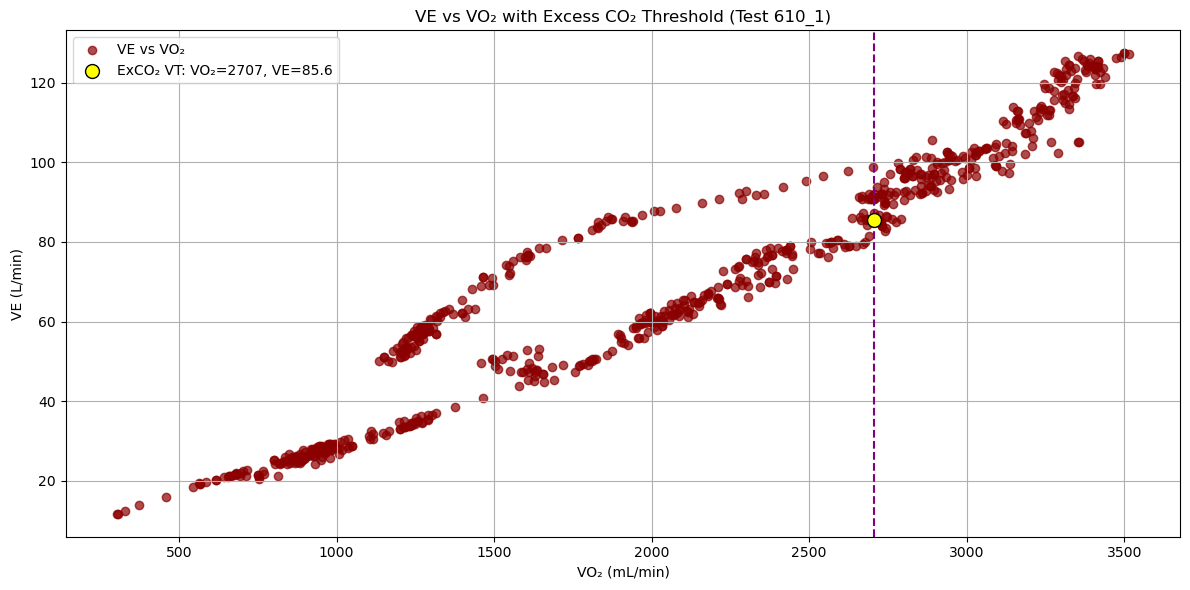

ExCO₂ VT Detected at VO₂: 2707.0 mL/min, HR: 171 bpm


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Subset data for target test
target_id_test = "610_1"
subset = data[data['ID_test'] == target_id_test].sort_values('time')

# Preprocess data
hr = subset['HR'].values
vo2 = subset['VO2'].values
vco2 = subset['VCO2'].values
ve = subset['VE'].values

# ---- Excess CO2 Method ----
vo2_safe = vo2.copy().astype(float)
vo2_safe[vo2_safe == 0] = 1e-8  # avoid division by zero

with np.errstate(divide='ignore', invalid='ignore'):
    exco2 = np.where(
        (vco2 == 0) & (vo2 == 0),
        0,
        (vco2**2 / vo2_safe) - vco2
    )

exco2 = np.nan_to_num(exco2, nan=0.0, posinf=0.0, neginf=0.0)
window_size = min(7, len(hr)//2*2-1)
exco2_smooth = savgol_filter(exco2, window_size, 2)

threshold = np.median(exco2_smooth) + 0.5*np.std(exco2_smooth)
vt_exco2_idx = np.argmax(exco2_smooth > threshold) if np.any(exco2_smooth > threshold) else None

# ---- Plot VE vs VO2 with VT ----
plt.figure(figsize=(12, 6))
plt.scatter(vo2, ve, c='darkred', label='VE vs VO₂', alpha=0.7)

# Add VT marker and line
if vt_exco2_idx is not None and vt_exco2_idx < len(vo2):
    vt_vo2 = vo2[vt_exco2_idx]
    vt_ve = ve[vt_exco2_idx]
    plt.scatter(vt_vo2, vt_ve, color='yellow', s=100, edgecolors='black',
                label=f'ExCO₂ VT: VO₂={vt_vo2:.0f}, VE={vt_ve:.1f}', zorder=5)
    plt.axvline(x=vt_vo2, color='purple', linestyle='--')

plt.title(f'VE vs VO₂ with Excess CO₂ Threshold (Test {target_id_test})')
plt.xlabel('VO₂ (mL/min)')
plt.ylabel('VE (L/min)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print result
if vt_exco2_idx is not None and vt_exco2_idx < len(hr):
    print(f"ExCO₂ VT Detected at VO₂: {vo2[vt_exco2_idx]:.1f} mL/min, HR: {hr[vt_exco2_idx]:.0f} bpm")
else:
    print("ExCO₂ VT could not be detected.")


[Filtered] Ventilatory Threshold estimated at VO2 ≈ 3197.00


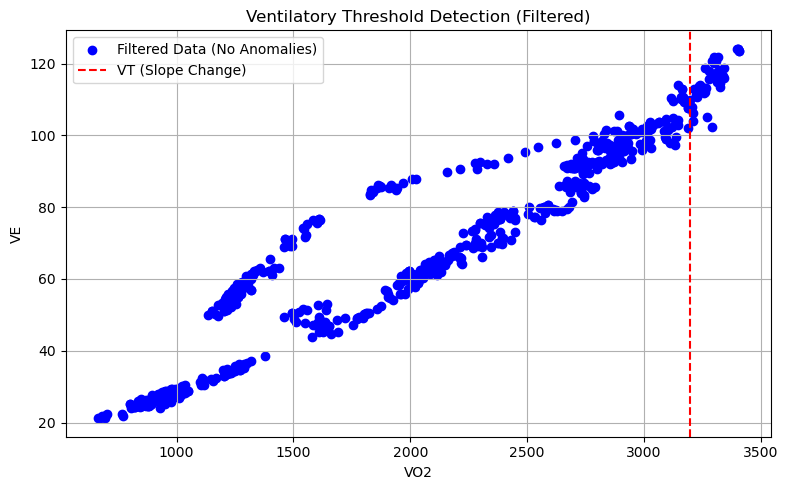

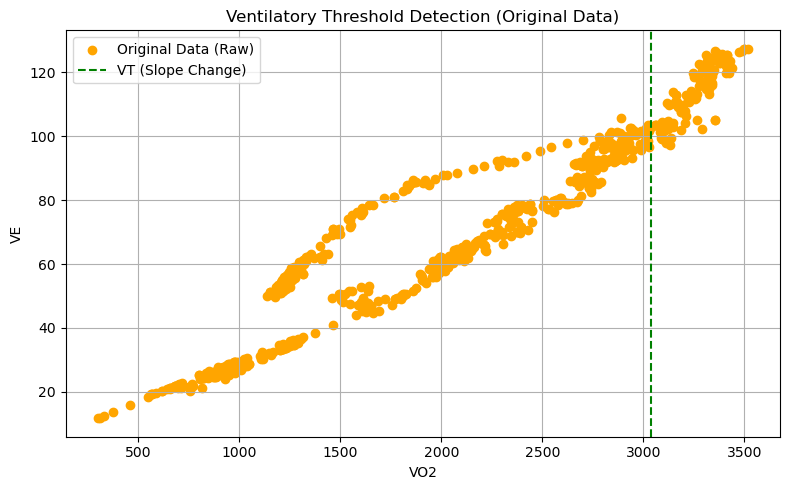

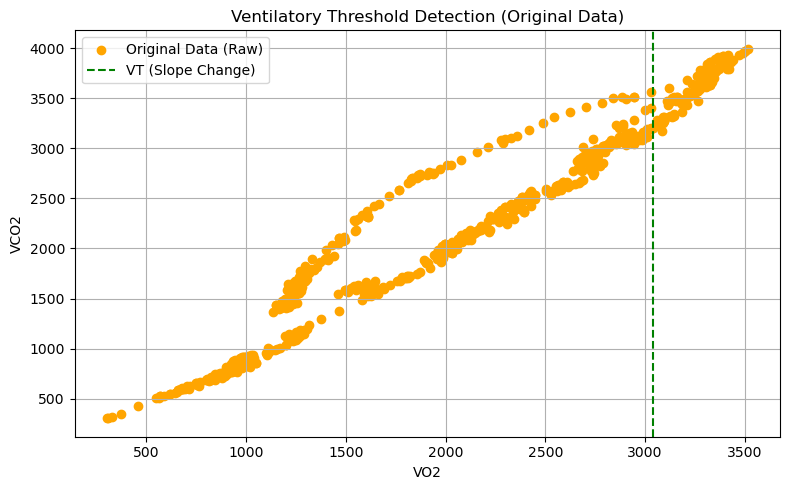

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
import pandas as pd
import os

# Set working directory and file path
working_directory = os.getcwd()
subject_info_path = os.path.join(working_directory, 'subject-info.csv')

# Load subject info data
subject_info = pd.read_csv(subject_info_path)
subject_measure_path = 'test_measure.csv'

# Load the dataset
data = pd.read_csv(subject_measure_path)

# Select specific ID_test
target_id_test = "610_1"
subset = data[data['ID_test'] == target_id_test]

# Drop missing values
subset = subset.dropna(subset=['VO2', 'VE'])

# --- Filtered Data (Anomalies Removed) ---
features = subset[['VO2', 'VE']].values
iso_forest = IsolationForest(contamination=0.10, random_state=42)
outlier_labels = iso_forest.fit_predict(features)

subset_filtered = subset[outlier_labels == 1]
x_filtered = subset_filtered['VO2'].values
y_filtered = subset_filtered['VE'].values

def find_best_split(x, y, min_points=5):
    best_split = None
    min_total_error = float('inf')

    for i in range(min_points, len(x) - min_points):
        model1 = LinearRegression().fit(x[:i].reshape(-1,1), y[:i])
        model2 = LinearRegression().fit(x[i:].reshape(-1,1), y[i:])

        error1 = np.sum((y[:i] - model1.predict(x[:i].reshape(-1,1)))**2)
        error2 = np.sum((y[i:] - model2.predict(x[i:].reshape(-1,1)))**2)

        total_error = error1 + error2

        if total_error < min_total_error:
            min_total_error = total_error
            best_split = i

    return best_split

# -- Plot for Filtered Data --
split_idx_filtered = find_best_split(x_filtered, y_filtered)
print(f"[Filtered] Ventilatory Threshold estimated at VO2 ≈ {x_filtered[split_idx_filtered]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_filtered, y_filtered, color='blue', label='Filtered Data (No Anomalies)')
plt.axvline(x_filtered[split_idx_filtered], color='red', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VE')
plt.title('Ventilatory Threshold Detection (Filtered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Original Data (No anomaly removal) ---
x_original = subset['VO2'].values
y_original = subset['VE'].values

# split_idx_original = find_best_split(x_original, y_original)
# print(f"[Original] Ventilatory Threshold estimated at VO2 ≈ {x_original[split_idx_original]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_original, y_original, color='orange', label='Original Data (Raw)')
plt.axvline(x_original[split_idx_filtered], color='green', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VE')
plt.title('Ventilatory Threshold Detection (Original Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



x_original = subset['VO2'].values
y_original = subset['VCO2'].values

# split_idx_original = find_best_split(x_original, y_original)
# print(f"[Original] Ventilatory Threshold estimated at VO2 ≈ {x_original[split_idx_original]:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(x_original, y_original, color='orange', label='Original Data (Raw)')
plt.axvline(x_original[split_idx_filtered], color='green', linestyle='--', label='VT (Slope Change)')
plt.xlabel('VO2')
plt.ylabel('VCO2')
plt.title('Ventilatory Threshold Detection (Original Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


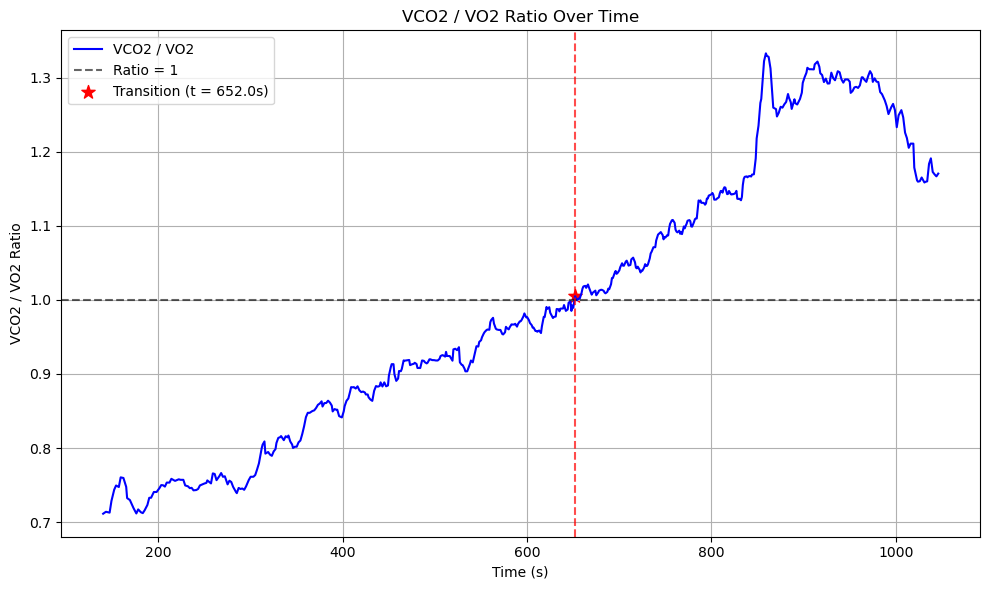

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('test_measure.csv')
subset = data[data['ID_test'] == "2_1"].dropna(subset=['VO2', 'VCO2'])
subset = subset.sort_values('time' if 'time' in subset.columns else 'VO2')

# --- 20-second averaging ---
# subset['VO2_20s'] = subset['VO2'].rolling(window=20, min_periods=1).mean()
# subset['VCO2_20s'] = subset['VCO2'].rolling(window=20, min_periods=1).mean()
# subset = subset.dropna(subset=['VO2_20s', 'VCO2_20s'])

# --- Calculate VCO2/VO2 ratio ---
# subset['VCO2_VO2_ratio'] = subset['VCO2_20s'] / subset['VO2_20s']


subset['VCO2_VO2_ratio'] = subset['VCO2'] / subset['VO2']


# --- Optional: Ignore first 10% of data ---
ignore_percent = 0.10
ignore_index = int(len(subset) * ignore_percent)
subset_clean = subset.iloc[ignore_index:].copy()

# --- Detect where ratio crosses 1 ---
cross_index = None
for i in range(1, len(subset_clean)):
    if subset_clean['VCO2_VO2_ratio'].iloc[i-1] < 1 and subset_clean['VCO2_VO2_ratio'].iloc[i] >= 1:
        cross_index = subset_clean.index[i]
        break

# --- Plot RER (VCO2 / VO2) over time ---
plt.figure(figsize=(10, 6))
plt.plot(subset_clean['time'], subset_clean['VCO2_VO2_ratio'], label='VCO2 / VO2', color='blue')
plt.axhline(1, color='black', linestyle='--', alpha=0.6, label='Ratio = 1')

# Mark transition point
if cross_index is not None:
    time_of_transition = subset_clean.loc[cross_index, 'time']
    ratio_at_transition = subset_clean.loc[cross_index, 'VCO2_VO2_ratio']
    plt.axvline(x=time_of_transition, color='red', linestyle='--', alpha=0.7)
    plt.scatter(time_of_transition, ratio_at_transition, color='red', s=100, marker='*', label=f'Transition (t = {time_of_transition:.1f}s)')

plt.xlabel('Time (s)')
plt.ylabel('VCO2 / VO2 Ratio')
plt.title('VCO2 / VO2 Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


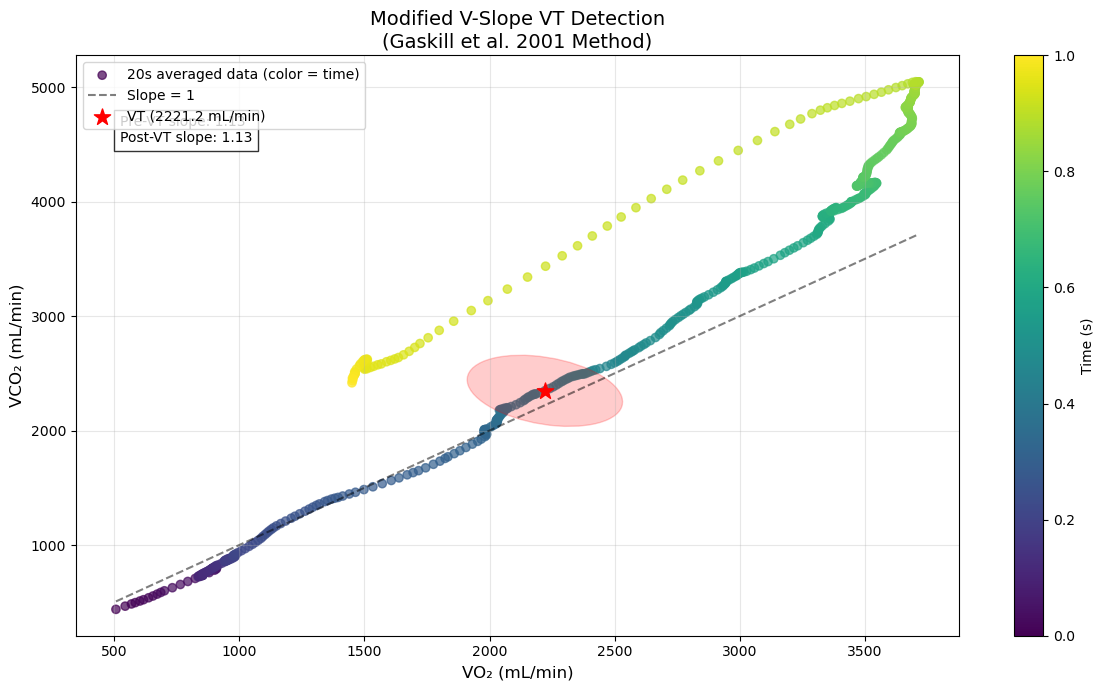


Final VT detection result: (2221.2, 517)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Ellipse

def detect_ventilatory_threshold(data_path, test_id="652_1", show_plot=True):
    """
    Implements the modified V-slope method from Gaskill et al. (2001) to detect VT.
    
    Parameters:
    - data_path: Path to CSV file containing gas exchange data
    - test_id: Identifier for the test to analyze
    - show_plot: Whether to display the diagnostic plot
    
    Returns:
    - vt_vo2: VO2 at ventilatory threshold (mL/min) or None if not detected
    - vt_time: Time at VT detection (seconds) or None
    """
    
    # Load and prepare data
    try:
        data = pd.read_csv(data_path)
        subset = data[data['ID_test'] == test_id].dropna(subset=['VO2', 'VCO2', 'time'])
        subset = subset.sort_values('time')
        
        if len(subset) < 40:
            print(f"Warning: Only {len(subset)} data points - insufficient for reliable VT detection")
            return None, None
            
    except Exception as e:
        print(f"Data loading error: {str(e)}")
        return None, None

    # 20-second averaging (aligned with paper's methodology)
    subset['VO2_20s'] = subset['VO2'].rolling(window=20, min_periods=10, center=True).mean()
    subset['VCO2_20s'] = subset['VCO2'].rolling(window=20, min_periods=10, center=True).mean()
    subset = subset.dropna(subset=['VO2_20s', 'VCO2_20s']).reset_index(drop=True)
    
    # Dynamic breakpoint detection
    def find_slope_breakpoint(df):
        X = df['VO2_20s'].values.reshape(-1, 1)
        y = df['VCO2_20s'].values
        best_break = None
        min_bic = float('inf')  # Using BIC for model selection
        
        # Require at least 20% of data in each segment
        min_idx = int(len(X) * 0.2)
        max_idx = len(X) - min_idx
        
        for i in range(min_idx, max_idx):
            # Fit two linear models
            m1 = LinearRegression().fit(X[:i], y[:i])
            m2 = LinearRegression().fit(X[i:], y[i:])
            
            # Calculate Bayesian Information Criterion
            resid = np.concatenate([y[:i] - m1.predict(X[:i]), 
                                  y[i:] - m2.predict(X[i:])])
            sigma2 = np.var(resid)
            bic = len(resid)*np.log(sigma2) + 2*np.log(len(resid))
            
            # Check slope increase (critical for VT)
            if (m2.coef_[0] > m1.coef_[0]) and (bic < min_bic):
                min_bic = bic
                best_break = i
                
        return df.iloc[best_break] if best_break is not None else None
    
    # Detect VT
    vt_point = find_slope_breakpoint(subset)
    vt_vo2 = vt_point['VO2_20s'] if vt_point is not None else None
    vt_time = vt_point['time'] if vt_point is not None else None
    
    # Quality checks (per Gaskill et al. 2001)
    if vt_time is not None:
        if vt_time < 240:
            print(f"VT detected at {vt_time:.1f}s (rejected - occurs before 4 minutes)")
            vt_vo2, vt_time = None, None
        elif vt_vo2 > subset['VO2_20s'].max() * 0.9:
            print(f"VT detected at {vt_vo2:.1f} mL/min (rejected - too close to VO2max)")
            vt_vo2, vt_time = None, None
    
    # Visualization
    if show_plot:
        plt.figure(figsize=(12, 7))
        
        # Main V-slope plot
        plt.scatter(subset['VO2_20s'], subset['VCO2_20s'], 
                   c=subset['time'], cmap='viridis', alpha=0.7, 
                   label='20s averaged data (color = time)')
        
        # Reference lines
        x_range = np.linspace(subset['VO2_20s'].min(), subset['VO2_20s'].max(), 100)
        plt.plot(x_range, x_range, 'k--', alpha=0.5, label='Slope = 1')
        
        if vt_point is not None:
            # Mark VT with uncertainty ellipse
            ellipse = Ellipse(xy=(vt_vo2, vt_point['VCO2_20s']),
                            width=subset['VO2_20s'].std()/2,
                            height=subset['VCO2_20s'].std()/2,
                            angle=45, color='red', alpha=0.2)
            plt.gca().add_patch(ellipse)
            
            plt.scatter(vt_vo2, vt_point['VCO2_20s'], 
                       color='red', s=150, marker='*',
                       label=f'VT ({vt_vo2:.1f} mL/min)')
            
            # Add slope info
            pre_idx = subset.index.get_loc(vt_point.name)
            pre_slope = LinearRegression().fit(
                subset.iloc[:pre_idx]['VO2_20s'].values.reshape(-1,1),
                subset.iloc[:pre_idx]['VCO2_20s'].values).coef_[0]
            
            post_slope = LinearRegression().fit(
                subset.iloc[pre_idx:]['VO2_20s'].values.reshape(-1,1),
                subset.iloc[pre_idx:]['VCO2_20s'].values).coef_[0]
            
            plt.text(0.05, 0.85, 
                    f'Pre-VT slope: {pre_slope:.2f}\nPost-VT slope: {post_slope:.2f}',
                    transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.xlabel('VO₂ (mL/min)', fontsize=12)
        plt.ylabel('VCO₂ (mL/min)', fontsize=12)
        plt.title('Modified V-Slope VT Detection\n(Gaskill et al. 2001 Method)', fontsize=14)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.colorbar(label='Time (s)')
        plt.tight_layout()
        plt.show()
    
    return vt_vo2, vt_time

# Example usage
if __name__ == "__main__":
    vt_result = detect_ventilatory_threshold('test_measure.csv')
    print(f"\nFinal VT detection result: {vt_result}")